# Extract_embeddings code

In [1]:
import pickle
from argparse import ArgumentParser
from pathlib import Path
from typing import Callable, List

import torch
from efficientnet_pytorch import EfficientNet
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

In [26]:
import os
import matplotlib.pyplot as plt

In [28]:
%matplotlib inline

In [3]:
os.chdir("E:/final/Dissertation/")

In [4]:
def get_model() -> torch.nn.Module:
    model = EfficientNet.from_pretrained("efficientnet-b0")
    model.eval()
    return model

In [5]:
def get_transform(width: int, height: int) -> Callable[[Image.Image], torch.Tensor]:
    """Provide a transform that converts image to a square and keeps the cell shape"""
    target_dim = max(width, height)
    w_pad = (target_dim - width) // 2
    h_pad = (target_dim - height) // 2
    transform = transforms.Compose([
        transforms.Pad(padding=(w_pad, h_pad)),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform

In [6]:
def get_image_embeddings(image: Path) -> List[float]:
    input_image = Image.open(image).convert("RGB")
    preprocess = get_transform(input_image.width, input_image.height)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    return output[0].cpu().detach().tolist()

In [7]:
import glob

# Input and output paths
input_path = "data/extracted/*/*.jpg"
output_path = "data/embeddings_efficientnetB0.pkl"

# Get a list of image paths using glob
image_paths = glob.glob(input_path)

# Process the images and save the embeddings
model = get_model()
mapping = {str(i): get_image_embeddings(image=i) for i in tqdm(sorted(image_paths))}
output_file = Path(output_path)
output_file.write_bytes(pickle.dumps(mapping))

Loaded pretrained weights for efficientnet-b0


100%|████████████████████████████████████████████████████████████████████████████████| 839/839 [00:22<00:00, 37.61it/s]


7650857

In [11]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

# Reduce dimensionality

In [12]:
import pickle
from argparse import ArgumentParser
from pathlib import Path
from typing import List, Optional, Tuple

import numpy as np
from loguru import logger
from sklearn.manifold import TSNE
from tqdm import tqdm

In [13]:
def load_embeddings(file: Path) -> Tuple[List[Path], np.ndarray]:
    embeddings = pickle.loads(file.read_bytes())
    files, vectors = zip(*list(embeddings.items()))
    return files, np.array(vectors)

In [14]:
def apply_tSNE(vectors: np.ndarray) -> np.ndarray:
    tSNE = TSNE(n_components=2, random_state=42)
    logger.info(f"Applying {tSNE}")
    return tSNE.fit_transform(vectors)

In [15]:
def reduce_dimensionality(embeddings_file: Path, output_file: Path):
    files, vectors = load_embeddings(file=embeddings_file)
    points = apply_tSNE(vectors=vectors)
    points_mapping = dict(zip(files, points))
    output_file.write_bytes(pickle.dumps(points_mapping))

In [16]:
points_path= "data/points_efficientnetb0.pkl"

In [17]:
reduce_dimensionality(
    output_file= Path(points_path),
    embeddings_file= Path(output_path))

2023-08-29 14:07:50.554 | INFO     | __main__:apply_tSNE:3 - Applying TSNE(random_state=42)


# Compute Clusters

In [18]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [19]:
def make_clusters(vectors: np.ndarray, n_clusters: int) -> np.ndarray:
    kMeans = KMeans(n_clusters=n_clusters, random_state=42)
    logger.info(f"Clustering with {kMeans}")
    return kMeans.fit_predict(vectors)

In [20]:
def find_optimal_number_of_clusters(values: List[int], data: np.ndarray) -> int:
    logger.info("Finding optimal value for k ...")
    inertias = [KMeans(n_clusters=n, random_state=42).fit(data).inertia_ for n in tqdm(values)]
    kneedle = KneeLocator(x=values, y=inertias, direction='decreasing', curve='convex')
    logger.info(inertias)
    logger.info(f"Optimal k={kneedle.elbow}")
    return kneedle.knee

In [24]:
def find_optimal_number_of_clusters(values: List[int], data: np.ndarray) -> int:
    logger.info("Finding optimal value for k ...")
    inertias = [KMeans(n_clusters=n, random_state=42).fit(data).inertia_ for n in tqdm(values)]
    kneedle = KneeLocator(x=values, y=inertias, direction='decreasing', curve='convex')
    
    # Plot the elbow curve
    plt.figure(figsize=(8, 6))
    plt.plot(values, inertias, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.vlines(kneedle.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
    plt.annotate(f'Optimal k={kneedle.elbow}', (kneedle.elbow + 1, inertias[0]), color='red')
    plt.show()

    logger.info(inertias)
    logger.info(f"Optimal k={kneedle.elbow}")
    return kneedle.knee


In [21]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [22]:
def compute_clusters(embeddings_file: Path, output_file: Path, clusters: Optional[int] = None):
    files, vectors = load_embeddings(file=embeddings_file)
    if clusters is None:
        clusters = find_optimal_number_of_clusters(range(5, 45, 5), data=vectors)
    clusters = make_clusters(vectors=vectors, n_clusters=clusters)
    cluster_mapping = dict(zip(files, clusters))
    output_file.write_bytes(pickle.dumps(cluster_mapping))
    # Calculate evaluation metrics
    silhouette_avg = silhouette_score(vectors, clusters)
    calinski_harabasz = calinski_harabasz_score(vectors, clusters)
    davies_bouldin = davies_bouldin_score(vectors, clusters)

    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz}")
    print(f"Davies-Bouldin Index: {davies_bouldin}")

2023-08-29 14:13:27.918 | INFO     | __main__:find_optimal_number_of_clusters:2 - Finding optimal value for k ...
  0%|                                                                                            | 0/8 [00:00<?, ?it/s]C:\Users\pavan\anaconda3\envs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\pavan\anaconda3\envs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
 12%|██████████▌                                                                         | 1/8 [00:00<00:02,  3.09it/s]C:\Users\pavan\anaconda3\envs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: Futu

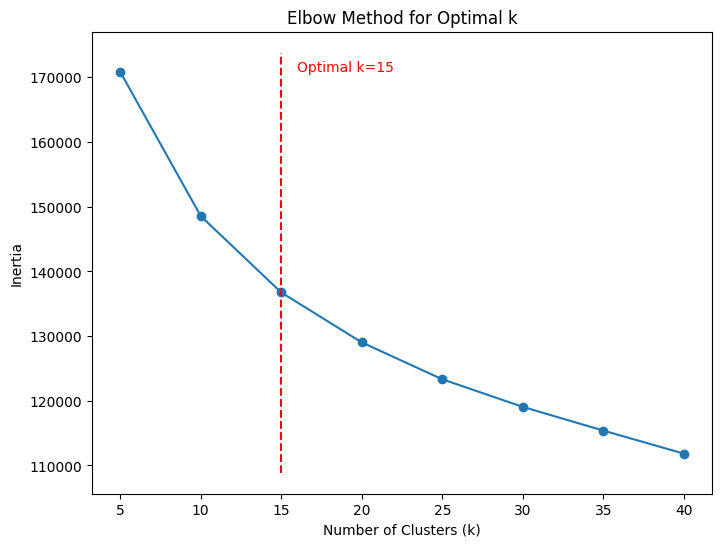

2023-08-29 14:13:32.306 | INFO     | __main__:find_optimal_number_of_clusters:16 - [170855.11600066742, 148556.10276415723, 136743.27164762854, 129025.34789030965, 123322.8633476067, 119056.82657242396, 115390.45930556835, 111829.74366774473]
2023-08-29 14:13:32.306 | INFO     | __main__:find_optimal_number_of_clusters:17 - Optimal k=15
2023-08-29 14:13:32.306 | INFO     | __main__:make_clusters:3 - Clustering with KMeans(n_clusters=15, random_state=42)
C:\Users\pavan\anaconda3\envs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\pavan\anaconda3\envs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  war

Silhouette Score: 0.07573931349451339
Calinski-Harabasz Index: 63.16621836577242
Davies-Bouldin Index: 2.3667018252904444


In [29]:
compute_clusters(
    embeddings_file=Path("data/embeddings_efficientnetB0.pkl"),
    output_file=Path("data/clusters_efficientb0.pkl")
)

# Export data to csv

In [30]:
import pandas as pd
from collections import defaultdict

In [31]:
def load_file_contents(file: Path) -> Tuple[List[Path], List]:
    return pickle.loads(file.read_bytes())

In [32]:
def export_csv(clusters_file: Path, points_file: Path, output_file: Path):
    clusters_data = load_file_contents(clusters_file)
    points_data = load_file_contents(points_file)

    data = defaultdict(dict)
    for key, cluster in clusters_data.items():
        data[key]["cluster"] = cluster
        point = points_data[key]
        data[key]["point_x"], data[key]["point_y"] = point

    df: pd.DataFrame = pd.DataFrame.from_dict(data, orient="index") \
        .rename_axis('cell_location') \
        .reset_index() \
        .assign(cell_location=lambda df: df.cell_location.apply(Path)) \
        .assign(parent_image=lambda df: df.cell_location.apply(lambda path: path.parent.name))

    df.to_csv(output_file, index=False)

In [33]:
export_csv(
        clusters_file=Path("data/clusters_efficientb0.pkl"),
        points_file=Path("data/points_efficientnetb0.pkl"),
        output_file=Path("data/export_efficientnetb0.csv"))

# Plots

In [34]:
from functools import partial
from multiprocessing import Lock, cpu_count
from multiprocessing.pool import ThreadPool
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from sklearn.manifold import TSNE

In [35]:
def load_file_contents(file: Path) -> Tuple[List[Path], np.ndarray]:
    data = pickle.loads(file.read_bytes())
    files, points = zip(*list(data.items()))
    return files, np.array(points)

In [36]:
lock = Lock()

In [37]:
def create_figure_2d(points: np.ndarray, clusters: np.ndarray, images: List[Path], limit_images: int = 500) -> go.FigureWidget:
    x = points[:, 0]
    y = points[:, 1]
    fig = px.scatter(x=x, y=y, color=clusters, opacity=0.75, size_max=5)
    np.random.seed(42)
    logger.info("Adding images to layout")
    with ThreadPool(cpu_count() * 4) as pool:
        shuffled_data = np.random.permutation(list(zip(images, x, y)))
        _ = list(tqdm(
            pool.imap(
                partial(add_image_to_layout, lock=lock, fig=fig),
                shuffled_data[:limit_images]
            ),
            total=min(len(images), limit_images))
        )
    return fig

In [38]:
def add_image_to_layout(image_x_y: Tuple[Path, float, float], fig: go.FigureWidget, lock: Lock):
    image, x, y = image_x_y
    pil_image = Image.open(image)
    lock.acquire()
    fig.add_layout_image(dict(
        source=pil_image,
        x=x,
        y=y,
        xref="x",
        yref="y",
        sizex=2,
        sizey=2,
        opacity=1,
        xanchor="center", yanchor="middle",
        layer="below",
    ))
    lock.release()


In [39]:
def create_figure(points: np.ndarray, clusters: np.ndarray, images: List[Path], limit_images: int) -> go.FigureWidget:
    fig = create_figure_2d(points=points, clusters=clusters, images=images, limit_images=limit_images)
    return fig

In [40]:
def prepare_plot(points_file: Path, clusters_file: Path, output_file: Path, limit_images: int):
    points_files, points = load_file_contents(file=points_file)
    _, clusters = load_file_contents(file=clusters_file)
    fig: go.FigureWidget = create_figure(points=points, clusters=clusters, images=points_files, limit_images=limit_images)
    output_file.write_text(fig.to_json())

In [41]:
prepare_plot(
        output_file=Path("data/plot_efficientnetb0.json"),
        points_file=Path("data/points_efficientnetb0.pkl"),
        clusters_file=Path("data/clusters_efficientb0.pkl"),
        limit_images=10000 )

2023-08-29 14:28:39.272 | INFO     | __main__:create_figure_2d:6 - Adding images to layout
100%|████████████████████████████████████████████████████████████████████████████████| 839/839 [04:13<00:00,  3.31it/s]


In [53]:
import json

# Visualise Embeddings

In [42]:
import json
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from functools import lru_cache

C:\Users\pavan\AppData\Local\Temp\ipykernel_20048\1277130376.py:3: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

C:\Users\pavan\AppData\Local\Temp\ipykernel_20048\1277130376.py:4: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



In [43]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)


def load_figure(file: Path) -> go.Figure:
    data = json.loads(file.read_text())
    fig = go.Figure(data=data)
    fig.update_traces(
        marker_size=12,
        selector=dict(mode='markers')
    )
    return fig

In [44]:
@lru_cache
def load_file_contents(file: Path) -> List[Path]:
    data = pickle.loads(file.read_bytes())
    files, points = zip(*list(data.items()))
    return files

def prepare_dash(fig: go.FigureWidget) -> dash.Dash:
    app.layout = html.Div([
        html.Pre(id="selection-data", style={"fontSize": "22px"}),
        dcc.Graph(figure=fig, id="scatter-plot", style={"width": "100vw", "height": "100vh"}),
    ])
    return app

In [45]:
@app.callback(
    Output(component_id='selection-data', component_property='children'),
    Input(component_id='scatter-plot', component_property='clickData')
)
def handle_selection(data):
    index = data['points'][0]["pointIndex"]
    files = load_file_contents(Path("data/embeddings_efficientnetb0.pkl"))
    
    return json.dumps(
        {
            "cell": files[index],
            "parent_image": Path(files[index]).parent.name
        }, indent=4
    )

In [46]:
figure = load_figure(file=Path("data/plot_efficientnetb0.json"))
dash = prepare_dash(fig=figure)
dash.run_server(port=8053,debug=False, use_reloader=False)


# Model Evaluation

In [47]:
#1. Parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
num_parameters = count_parameters(model)
print(f"Number of parameters in the model: {num_parameters}")

Number of parameters in the model: 5288548
